<a href="https://colab.research.google.com/github/tronghieu2810/DEEP-LEARNING/blob/main/UDM_ZTM_DL/MY_CODE/08_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
!wget https://raw.githubusercontent.com/tronghieu2810/DEEP-LEARNING/main/helper_DL.py

--2022-04-09 03:00:53--  https://raw.githubusercontent.com/tronghieu2810/DEEP-LEARNING/main/helper_DL.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26611 (26K) [text/plain]
Saving to: ‘helper_DL.py’

helper_DL.py        100%[===================>]  25.99K  --.-KB/s    in 0.001s  

2022-04-09 03:00:53 (19.3 MB/s) - ‘helper_DL.py’ saved [26611/26611]



In [123]:
!pip install colorama
import helper_DL as helper
import random
import time

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import tensorflow_hub as hub

# Text dataset

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
helper.unzip_data('nlp_getting_started.zip')

--2022-04-09 03:01:14--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 173.194.194.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2022-04-09 03:01:14 (133 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



# Explore data

In [4]:
train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv')

print(train_df.head(), '\n')
print(train_df.target.value_counts(), '\n') # How many examples of each class?
print(len(train_df), len(test_df), '\n') # How many total examples?

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1   

0    4342
1    3271
Name: target, dtype: int64 

7613 3263 



In [5]:
# Shuffle training datafram
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
# Visualize some random training examples
random_index = random.randint(0, len(train_df)-5) # Create random index not higher than the number of samples
for row in train_df_shuffled[['text', 'target']][random_index:random_index+5].itertuples(): # Turning values in DF into a tuple (text, target)
    # _: Get rid of index
    _, text, target = row
    print(f'Target: {target} ', '(real disaster)' if (target > 0) else '(not real disaster)')
    print(f'Text:   {text}\n')
    print('---\n')


Target: 0  (not real disaster)
Text:   don't stop believing just came on the radio at this restaurant and a lil white bit screamed 'it's mommys song'

---

Target: 1  (real disaster)
Text:   New Giant Flames (GIANT FULL BLACK PANTOFEL) info/order sms:087809233445 pin:23928835 http://t.co/dthNEezupe  pic.twitter.com/pNPiZoDY

---

Target: 1  (real disaster)
Text:   Spokane authorities say they're struggling to solve arson cases like today's on Hamilton. http://t.co/Qbs2k01WzK http://t.co/mvLZIYsGLL

---

Target: 1  (real disaster)
Text:   TRUCK ABLAZE : R21. VOORTREKKER AVE. OUTSIDE OR TAMBO INTL. CARGO SECTION. http://t.co/8kscqKfKkF

---

Target: 1  (real disaster)
Text:   rgj: Truck trailer catches fire in Reno http://t.co/kAF3WdRmTn

---



# Splitting data into training and validation sets

In [8]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                            train_df_shuffled['target'].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [9]:
print(f'{len(train_sentences)} - {len(val_sentences)} - {len(train_labels)} - {len(val_labels)}\n')
print(train_sentences[:5], '\n')
print(train_labels[:5], '\n')

6851 - 762 - 6851 - 762

['@mogacola @zamtriossu i screamed after hitting tweet'
 'Imagine getting flattened by Kurt Zouma'
 '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....'
 "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet"
 'Somehow find you and I collide http://t.co/Ee8RpOahPk'] 

[0 0 1 0 0] 



# Converting text data to numbers using tokenisation and embeddings

In [10]:
text_vectorizer = TextVectorization(max_tokens=None,
                                    standardize='lower_and_strip_punctuation',
                                    split='whitespace',
                                    ngrams=None,
                                    output_mode='int',
                                    output_sequence_length=None)

In [11]:
print(train_sentences, '\n')
print(train_sentences[0], '\n')
print(train_sentences[0].split(), '\n')
print(len(train_sentences[0].split()), '\n')
print(round(sum([len(i.split()) for i in train_sentences])), '\n')
print(round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences)), '\n')

['@mogacola @zamtriossu i screamed after hitting tweet'
 'Imagine getting flattened by Kurt Zouma'
 '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....'
 ...
 'Near them on the sand half sunk a shattered visage lies... http://t.co/0kCCG1BT06'
 "kesabaran membuahkan hasil indah pada saat tepat! life isn't about waiting for the storm to pass it's about learning to dance in the rain."
 "@ScottDPierce @billharris_tv @HarrisGle @Beezersun I'm forfeiting this years fantasy football pool out of fear I may win n get my ass kicked"] 

@mogacola @zamtriossu i screamed after hitting tweet 

['@mogacola', '@zamtriossu', 'i', 'screamed', 'after', 'hitting', 'tweet'] 

7 

102087 

15 



In [12]:
max_vocab_length = 10000
max_length       = round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences)) # Max length our sequences will be (number of words)
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

# Mapping the TextVectorization layer to text data and turning it into numbers

In [13]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [14]:
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [15]:
random_sentence = random.choice(train_sentences)
print(f'Original text:      {random_sentence}\
      \nVectorized version: {text_vectorizer([random_sentence])}')

Original text:      @bettyfreedoms @AbnInfVet hillary mass murderer.      
Vectorized version: [[   1    1 3777  157  538    0    0    0    0    0    0    0    0    0
     0]]


In [16]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]

print(f'Number of words in vocab: {len(words_in_vocab)}')
print(f'5 most common words:      {top_5_words}')
print(f'5 least common words:     {bottom_5_words}')

Number of words in vocab: 10000
5 most common words:      ['', '[UNK]', 'the', 'a', 'in']
5 least common words:     ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


# Creating an Embedding layer to turn tokenised text into embedding vectors

In [17]:
embedding = tfk.layers.Embedding(input_dim=max_vocab_length,
                                 output_dim=128,
                                 input_length=max_length)
embedding

In [18]:
random_sentence = random.choice(train_sentences)
print(f'Original text:\n{random_sentence}\n')

sample_embed = embedding(text_vectorizer([random_sentence]))
print(f'Embedded version: '), print(sample_embed)
print()

print(sample_embed[0][0])
print(sample_embed[0][0].shape)
print(random_sentence)

Original text:
Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife #islam

Embedded version: 
tf.Tensor(
[[[-0.01552739 -0.02307343 -0.01090856 ...  0.00891138  0.01830572
    0.00445269]
  [ 0.04622957  0.01153659 -0.00192131 ... -0.02443842 -0.00696586
    0.03060528]
  [ 0.04976993 -0.01790943 -0.01688346 ...  0.01360018 -0.00879816
   -0.00339488]
  ...
  [-0.04431365 -0.0378411   0.01420322 ...  0.0371697  -0.00750326
   -0.00767351]
  [-0.03686124  0.04799496  0.02086569 ...  0.02072097  0.04174973
    0.01934547]
  [ 0.02387578  0.01544433  0.03621701 ...  0.04981193 -0.04583945
    0.03280859]]], shape=(1, 15, 128), dtype=float32)

tf.Tensor(
[-0.01552739 -0.02307343 -0.01090856 -0.04167812  0.0497137   0.04996736
 -0.00959309 -0.03961843 -0.01547253 -0.02106478  0.00885767 -0.03890041
 -0.02963399 -0.02861636  0.03442372 -0.02420207 -0.02130215  0.00494671
  0.02054887 -0.00287441 -0.02643588 -0.04434146  0.03769595  0.01680164


# Model 0: Building a baseline model to try and improve upon

In [19]:
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())                    
])

model_0.fit(train_sentences, train_labels)
baseline_score = model_0.score(val_sentences, val_labels)
print(f'Our baseline model achieves an accuracy of: {baseline_score * 100:.2f}%')


Our baseline model achieves an accuracy of: 79.27%


# Creating a function to track and evaluate our model's results

In [20]:
def calculate_results(y_true, y_pred):
    """
    - Calculates model accuracy, precision, recall and f1 score of a binary classification model.
    """

    model_accuracy = accuracy_score(y_true, y_pred) * 100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,
                                                                                 y_pred,
                                                                                 average='weighted')
    
    model_results = {'accuracy':  round(model_accuracy, 2),
                     'precision': round(model_precision, 2),
                     'recall':    round(model_recall, 2),
                     'f1':        round(model_f1, 2)}

    return model_results

In [21]:
baseline_preds = model_0.predict(val_sentences)
baseline_results = calculate_results(y_true=val_labels, y_pred=baseline_preds)
print(baseline_results)

{'accuracy': 79.27, 'precision': 0.81, 'recall': 0.79, 'f1': 0.79}


In [22]:
round(2.1111, 2)

2.11

# Model 1: Building, fitting and evaluating our first deep model on text data

In [23]:
SAVE_DIR = 'model_logs'

inputs = tfk.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tfk.layers.GlobalAveragePooling1D()(x)
outputs = tfk.layers.Dense(1, activation='sigmoid')(x)

model_1 = tfk.Model(inputs, outputs, name='model_1_dense')
model_1.compile(loss='binary_crossentropy',
                optimizer=tfk.optimizers.Adam(),
                metrics=['accuracy'])

model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [24]:
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[helper.create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                            experiment_name='model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20220409-030117
Epoch 1/5
215/215 [==============================] - 6s 25ms/step - loss: 0.6121 - accuracy: 0.6904 - val_loss: 0.5409 - val_accuracy: 0.7480
Epoch 2/5
215/215 [==============================] - 6s 28ms/step - loss: 0.4424 - accuracy: 0.8159 - val_loss: 0.4743 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 6s 26ms/step - loss: 0.3469 - accuracy: 0.8602 - val_loss: 0.4628 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 6s 27ms/step - loss: 0.2836 - accuracy: 0.8915 - val_loss: 0.4660 - val_accuracy: 0.7861
Epoch 5/5
215/215 [==============================] - 6s 28ms/step - loss: 0.2375 - accuracy: 0.9127 - val_loss: 0.4816 - val_accuracy: 0.7808


In [25]:
model_1_pred_probs = model_1.predict(val_sentences)
print(model_1_pred_probs.shape)
print(model_1_pred_probs[0], val_labels[0])
print()

model_1_pred_probs = tf.squeeze(model_1_pred_probs)
print(model_1_pred_probs.shape)

(762, 1)
[0.40951604] 0

(762,)


In [26]:
model_1_preds = tf.round(model_1_pred_probs)
print(model_1_preds[:10])

tf.Tensor([0. 1. 1. 0. 0. 1. 1. 1. 1. 0.], shape=(10,), dtype=float32)


In [27]:
model_1_results = calculate_results(y_true=val_labels, y_pred=model_1_preds)
print(model_1_results)
print(baseline_results)
print(np.array(list(model_1_results.values())) > np.array(list(baseline_results.values())))

{'accuracy': 78.08, 'precision': 0.78, 'recall': 0.78, 'f1': 0.78}
{'accuracy': 79.27, 'precision': 0.81, 'recall': 0.79, 'f1': 0.79}
[False False False False]


# Visualising our model's learned word embeddings with TensorFlow's projector too

In [28]:
words_in_vocab = text_vectorizer.get_vocabulary()
print(len(words_in_vocab), words_in_vocab[:10])

10000 ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']


In [29]:
embed_weights = model_1.get_layer('embedding').get_weights()[0]
print(embed_weights, embed_weights.shape)

[[ 0.06868201 -0.02231645 -0.00044085 ... -0.0264012   0.00451367
  -0.05681162]
 [-0.0013253   0.01301463  0.00426587 ... -0.02496698 -0.04452747
  -0.03930094]
 [-0.01803764  0.0237759  -0.04706891 ... -0.01374004 -0.00334152
  -0.02129962]
 ...
 [-0.0183093   0.01456288  0.04976762 ... -0.03983175 -0.03711892
  -0.00199366]
 [ 0.00878946  0.00801481 -0.06471687 ... -0.00575518  0.00535406
  -0.01649981]
 [ 0.04024557 -0.0125607  -0.06138333 ... -0.00803439 -0.07336622
  -0.06746805]] (10000, 128)


In [30]:
# import io
# out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
# out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

# for index, word in enumerate(words_in_vocab):
#   if index == 0:
#     continue  # skip 0, it's padding.
#   vec = embed_weights[index]
#   out_v.write('\t'.join([str(x) for x in vec]) + "\n")
#   out_m.write(word + "\n")
# out_v.close()
# out_m.close()

In [31]:
# try:
#     from google.colab import files
#     files.download('vectors.tsv')
#     files.download('metadata.tsv')
# except Exception:
#     pass

# Model 2: Building, fitting and evaluating our first TensorFlow RNN model (LSTM)

In [32]:
inputs = tfk.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tfk.layers.LSTM(units=64)(x)
x = tfk.layers.Dense(units=64, activation='relu')(x)
outputs = tfk.layers.Dense(units=1, activation='sigmoid')(x)

model_2 = tfk.Model(inputs, outputs, name='model_2_LSTM')

model_2.compile(loss='binary_crossentropy',
                optimizer=tfk.optimizers.Adam(),
                metrics=['accuracy'])

print(model_2.summary(), '\n')

model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[helper.create_tensorboard_callback(SAVE_DIR,
                                                                            'model_2_LSTM')])

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                      

In [33]:
model_2_pred_probs = model_2.predict(val_sentences)
print(model_2_pred_probs[:5])

model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
print(model_2_preds[:5])
print(val_labels[:5], '\n')

[[1.4272630e-03]
 [7.4659848e-01]
 [9.9993527e-01]
 [1.0925829e-03]
 [1.7142964e-05]]
tf.Tensor([0. 1. 1. 0. 0.], shape=(5,), dtype=float32)
[0 0 1 1 1] 



In [34]:
model_2_results = calculate_results(y_true=val_labels, y_pred=model_2_preds)
print(model_2_results)
print(baseline_results)

{'accuracy': 78.08, 'precision': 0.78, 'recall': 0.78, 'f1': 0.78}
{'accuracy': 79.27, 'precision': 0.81, 'recall': 0.79, 'f1': 0.79}


# Model 3: Building, fitting and evaluating a GRU-cell powered RNN

In [35]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, return_sequences=True)(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tfk.Model(inputs, outputs, name='model_3_GRU')

model_3.summary()

model_3.compile(loss='binary_crossentropy',
                optimizer=tfk.optimizers.Adam(),
                metrics=['accuracy'])

model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[helper.create_tensorboard_callback(SAVE_DIR,
                                                                            'model_3_GRU')])

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 15, 64)            37248     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 1)                 

In [36]:
model_3_pred_probs = model_3.predict(val_sentences)
print(model_3_pred_probs.shape)
print(model_3_pred_probs[:5])
print()

model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
print(model_3_preds.shape)
print(model_3_preds[:5])
print()

model_3_results = calculate_results(y_true=val_labels, y_pred=model_3_preds)
print(model_3_results)

(762, 1)
[[1.4523059e-02]
 [8.1732380e-01]
 [9.9981797e-01]
 [6.6167325e-02]
 [4.3085217e-04]]

(762,)
tf.Tensor([0. 1. 1. 0. 0.], shape=(5,), dtype=float32)

{'accuracy': 76.9, 'precision': 0.78, 'recall': 0.77, 'f1': 0.76}


# Model 4: Building, fitting and evaluating a bidirectional RNN model

In [37]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_4 = tfk.Model(inputs, outputs, name='model_4_bidirectional')

model_4.summary()

model_4.compile(loss='binary_crossentropy',
                optimizer=tfk.optimizers.Adam(),
                metrics=['accuracy'])

model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[helper.create_tensorboard_callback(SAVE_DIR,
                                                                            'model_4_bidirectional')])

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [38]:
model_4_pred_probs = model_4.predict(val_sentences)
print(model_4_pred_probs[:5])

model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
print(model_4_preds[:5])
print()

model_4_results = calculate_results(y_true=val_labels, y_pred=model_4_preds)
print(model_4_results)

[[6.1747432e-04]
 [6.4594728e-01]
 [9.9990255e-01]
 [2.3551235e-01]
 [5.4419423e-05]]
tf.Tensor([0. 1. 1. 0. 0.], shape=(5,), dtype=float32)

{'accuracy': 77.69, 'precision': 0.78, 'recall': 0.78, 'f1': 0.77}


# Model 5: Building, fitting and evaluating a 1D CNN for text

In [39]:
embedding_test = embedding(text_vectorizer(['this is a test sentence']))

conv_1d = layers.Conv1D(filters=32, 
                        kernel_size=5, 
                        activation='relu', 
                        padding='valid')
conv_1d_output = conv_1d(embedding_test)

max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)

print(embedding_test.shape)
print(conv_1d_output.shape)
print(max_pool_output.shape)

(1, 15, 128)
(1, 11, 32)
(1, 32)


In [42]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation='relu', padding='valid')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_5 = tfk.Model(inputs, outputs, name='model_5_Conv1D')

model_5.compile(loss='binary_crossentropy',
                optimizer=tfk.optimizers.Adam(),
                metrics=['accuracy'])

model_5.summary()

model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[helper.create_tensorboard_callback(SAVE_DIR,
                                                                            'Conv1D')])

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_2 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 1)              

In [43]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_results = calculate_results(y_true=val_labels, y_pred=model_5_preds)

print(model_5_pred_probs[:5], model_5_pred_probs.shape, '\n')
print(model_5_preds[:5], '\n')
print(model_5_results)

[[6.473519e-01]
 [9.280760e-01]
 [9.999814e-01]
 [8.375171e-02]
 [4.760007e-06]] (762, 1) 

tf.Tensor([1. 1. 1. 0. 0.], shape=(5,), dtype=float32) 

{'accuracy': 75.72, 'precision': 0.76, 'recall': 0.76, 'f1': 0.76}


# Using TensorFlow Hub for pretrained word embeddings (transfer learning for NLP)

In [47]:
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

In [50]:
embed_samples = embed([sample_sentence])
print(embed_samples.shape)
print(embed_samples[0])

(1, 512)
tf.Tensor(
[-0.01157023  0.0248591   0.0287805  -0.012715    0.0397154   0.08827761
  0.02680985  0.05589836 -0.01068731 -0.00597294  0.00639323 -0.01819518
  0.00030816  0.09105889  0.05874644 -0.03180627  0.01512473 -0.05162927
  0.00991365 -0.06865345 -0.04209307  0.02678979  0.03011006  0.00321066
 -0.00337968 -0.04787358  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666384  0.056303   -0.03949255  0.00517686  0.02495824 -0.07014441
  0.02871509  0.04947678 -0.00633977 -0.08960192  0.02807121 -0.00808365
 -0.01360599  0.0599865  -0.10361788 -0.05195372  0.00232955 -0.0233253
 -0.03758106  0.03327728 -0.00430603 -0.05894246 -0.06101274 -0.02220005
 -0.01575761 -0.00474411 -0.03515062 -0.04440378 -0.04174352  0.04943503
 -0.02740932 -0.041331    0.01634345 -0.0371368   0.07395209 -0.00659237
 -0.06943311 -0.00361752  0.08656701  0.07717379 -0.06633056  0.02086629
  0.06676424  0.00982107  0.01410715  0.07672232  0.05026635  0.02969933
 -0.01391872  0.06082513  0.0896

In [51]:
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE')

In [53]:
model_6 = tfk.Sequential([sentence_encoder_layer,
                          layers.Dense(1, activation='sigmoid')],
                         name='model_6_USE')
model_6.compile(loss='binary_crossentropy',
                optimizer=tfk.optimizers.Adam(),
                metrics=['accuracy'])
model_6.summary()
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[helper.create_tensorboard_callback(SAVE_DIR,
                                                                            'tf_hub_sentence_encoder')])

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                                 
Total params: 256,798,337
Trainable params: 513
Non-trainable params: 256,797,824
_________________________________________________________________
Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20220409-034153
Epoch 1/5
215/215 [==============================] - 10s 23ms/step - loss: 0.6488 - accuracy: 0.7211 - val_loss: 0.6134 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.5818 - accuracy: 0.7841 - val_loss: 0.5644 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 4s 17ms/step 

In [58]:
model_6_pred_probs = model_6.predict(val_sentences)
print(model_6_pred_probs[:5]), print()

model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
print(model_6_preds[:5]), print()

model_6_results = calculate_results(y_true=val_labels, y_pred=model_6_preds)
print(model_6_results)

[[0.3768071 ]
 [0.6755946 ]
 [0.86114705]
 [0.34265015]
 [0.6291756 ]]

tf.Tensor([0. 1. 1. 0. 1.], shape=(5,), dtype=float32)

{'accuracy': 79.27, 'precision': 0.79, 'recall': 0.79, 'f1': 0.79}


In [62]:
model_6a = tfk.Sequential([sentence_encoder_layer,
                          layers.Dense(128, activation='relu'),
                          layers.Dense(1, activation='sigmoid')],
                         name='model_6a_USE')
model_6a.compile(loss='binary_crossentropy',
                optimizer=tfk.optimizers.Adam(),
                metrics=['accuracy'])
model_6a.summary()
model_6a_history = model_6a.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[helper.create_tensorboard_callback(SAVE_DIR,
                                                                            'tf_hub_sentence_encoder')])

print()
model_6a_pred_probs = model_6a.predict(val_sentences)
print(model_6a_pred_probs[:5]), print()

model_6a_preds = tf.squeeze(tf.round(model_6a_pred_probs))
print(model_6a_preds[:5]), print()

model_6a_results = calculate_results(y_true=val_labels, y_pred=model_6a_preds)
print(model_6a_results)

Model: "model_6a_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_11 (Dense)            (None, 128)               65664     
                                                                 
 dense_12 (Dense)            (None, 1)                 129       
                                                                 
Total params: 256,863,617
Trainable params: 65,793
Non-trainable params: 256,797,824
_________________________________________________________________
Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20220409-035826
Epoch 1/5
215/215 [==============================] - 7s 19ms/step - loss: 0.4901 - accuracy: 0.7860 - val_loss: 0.4456 - val_accuracy: 0.8071
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss:

# Preparing subsets of data for model 7 (same as model 6 but 10% of data)

In [64]:
train_df_shuffled

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0
...,...,...,...,...,...
5226,7470,obliteration,Merica!,@Eganator2000 There aren't many Obliteration s...,0
5390,7691,panic,NaN,just had a panic attack bc I don't have enough...,0
860,1242,blood,NaN,Omron HEM-712C Automatic Blood Pressure Monito...,0
7603,10862,NaN,NaN,Officials say a quarantine is in place at an A...,1


In [71]:
train_10_percent = train_df_shuffled[['text', 'target']].sample(frac=0.1, random_state=42)
print(train_10_percent.head(1), len(train_10_percent)), print()

train_sentences_10_percent = train_10_percent['text'].to_list()
train_labels_10_percent = train_10_percent['target'].to_list()
print(len(train_sentences_10_percent), len(train_labels_10_percent)), print()

print(train_10_percent['target'].value_counts())
print(train_df_shuffled['target'].value_counts())

                                                   text  target
4955  DFR EP016 Monthly Meltdown - On Dnbheaven 2015...       0 761

761 761

0    413
1    348
Name: target, dtype: int64
0    4342
1    3271
Name: target, dtype: int64


# Model 7: Building, training and evaluating a transfer learning model on 10% data

In [78]:
model_7 = tfk.Sequential([sentence_encoder_layer,
                          layers.Dense(128, activation='relu'),
                          layers.Dense(1, activation='sigmoid')],
                         name='model_6a_USE')
model_7.compile(loss='binary_crossentropy',
                optimizer=tfk.optimizers.Adam(),
                metrics=['accuracy'])

model_7.summary(), print()

model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[helper.create_tensorboard_callback(SAVE_DIR,
                                                                            'tf_hub_sentence_encoder_10_percent')])



Model: "model_6a_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_17 (Dense)            (None, 128)               65664     
                                                                 
 dense_18 (Dense)            (None, 1)                 129       
                                                                 
Total params: 256,863,617
Trainable params: 65,793
Non-trainable params: 256,797,824
_________________________________________________________________

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent/20220409-042649
Epoch 1/5
24/24 [==============================] - 5s 73ms/step - loss: 0.6584 - accuracy: 0.7109 - val_loss: 0.6030 - val_accuracy: 0.8031
Epoch 2/5
24/24 [==============================] - 1s 27ms/step

In [79]:
model_7_pred_probs = model_7.predict(val_sentences)
print(model_7_pred_probs[:5])

model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
print(model_7_preds[:5]), print()

model_7_results = calculate_results(y_true=val_labels, y_pred=model_7_preds)
print(model_7_results)

[[0.18137464]
 [0.8269342 ]
 [0.9461236 ]
 [0.3044838 ]
 [0.8575606 ]]
tf.Tensor([0. 1. 1. 0. 1.], shape=(5,), dtype=float32)

{'accuracy': 83.99, 'precision': 0.84, 'recall': 0.84, 'f1': 0.84}


# Fixing our data leakage issue with model 7 and retraining it

In [89]:
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
print(train_10_percent_split, len(train_sentences))
print(len(train_10_percent))
print(train_10_percent[:5]), print()

train_labels_10_percent = train_labels[:train_10_percent_split]
print(len(train_labels_10_percent))
print(train_labels_10_percent[:5])
print(pd.Series(train_labels_10_percent).value_counts())

685 6851
685
['@mogacola @zamtriossu i screamed after hitting tweet'
 'Imagine getting flattened by Kurt Zouma'
 '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....'
 "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet"
 'Somehow find you and I collide http://t.co/Ee8RpOahPk']

685
[0 0 1 0 0]
0    406
1    279
dtype: int64


In [90]:
model_7 = tfk.Sequential([sentence_encoder_layer,
                          layers.Dense(128, activation='relu'),
                          layers.Dense(1, activation='sigmoid')],
                         name='model_6a_USE')
model_7.compile(loss='binary_crossentropy',
                optimizer=tfk.optimizers.Adam(),
                metrics=['accuracy'])

model_7.summary(), print()

model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[helper.create_tensorboard_callback(SAVE_DIR,
                                                                            'tf_hub_sentence_encoder_10_percent_correct_split')])
print()

model_7_pred_probs = model_7.predict(val_sentences)
print(model_7_pred_probs[:5])

model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
print(model_7_preds[:5]), print()

model_7_results = calculate_results(y_true=val_labels, y_pred=model_7_preds)
print(model_7_results)

Model: "model_6a_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_19 (Dense)            (None, 128)               65664     
                                                                 
 dense_20 (Dense)            (None, 1)                 129       
                                                                 
Total params: 256,863,617
Trainable params: 65,793
Non-trainable params: 256,797,824
_________________________________________________________________

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20220409-044513
Epoch 1/5
22/22 [==============================] - 4s 117ms/step - loss: 0.6614 - accuracy: 0.7051 - val_loss: 0.6303 - val_accuracy: 0.7507
Epoch 2/5
22/22 [==============================]

# Comparing all our modelling experiments evaluation metrics

In [96]:
all_model_results = pd.DataFrame({'0_baseline': baseline_results,
                                  '1_simple_dense': model_1_results,
                                  '2_lstm': model_2_results,
                                  '3_gru': model_3_results,
                                  '4_bidirectional': model_4_results,
                                  '5_conv1d': model_5_results,
                                  '6_tf_hub_use_encoder': model_6_results,
                                  '7_tf_hub_use_encoder_10_percent': model_7_results})
all_model_results = all_model_results.T
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.27,0.81,0.79,0.79
1_simple_dense,78.08,0.78,0.78,0.78
2_lstm,78.08,0.78,0.78,0.78
3_gru,76.90,0.78,0.77,0.76
4_bidirectional,77.69,0.78,0.78,0.77
5_conv1d,75.72,0.76,0.76,0.76
6_tf_hub_use_encoder,79.27,0.79,0.79,0.79
7_tf_hub_use_encoder_10_percent,77.95,0.78,0.78,0.78


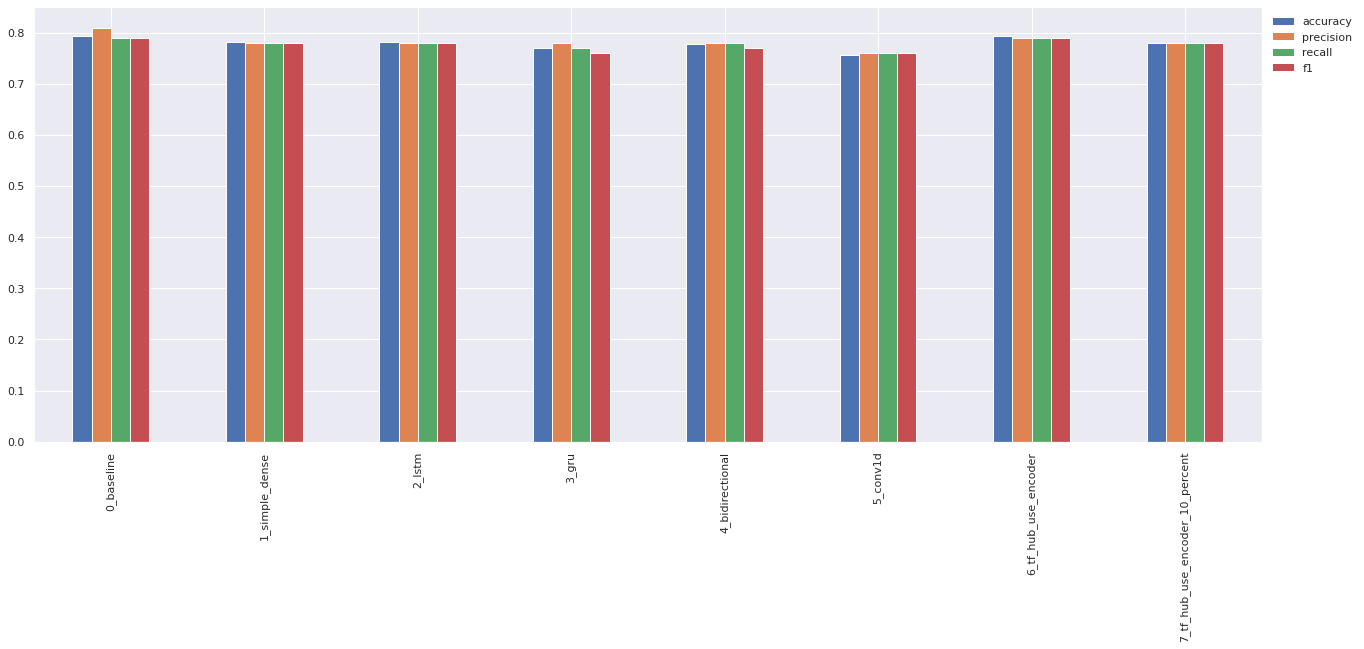

In [97]:
all_model_results['accuracy'] = all_model_results['accuracy'] / 100

all_model_results.plot.bar(figsize=(22, 8)).legend(bbox_to_anchor=(1.0, 1.0));

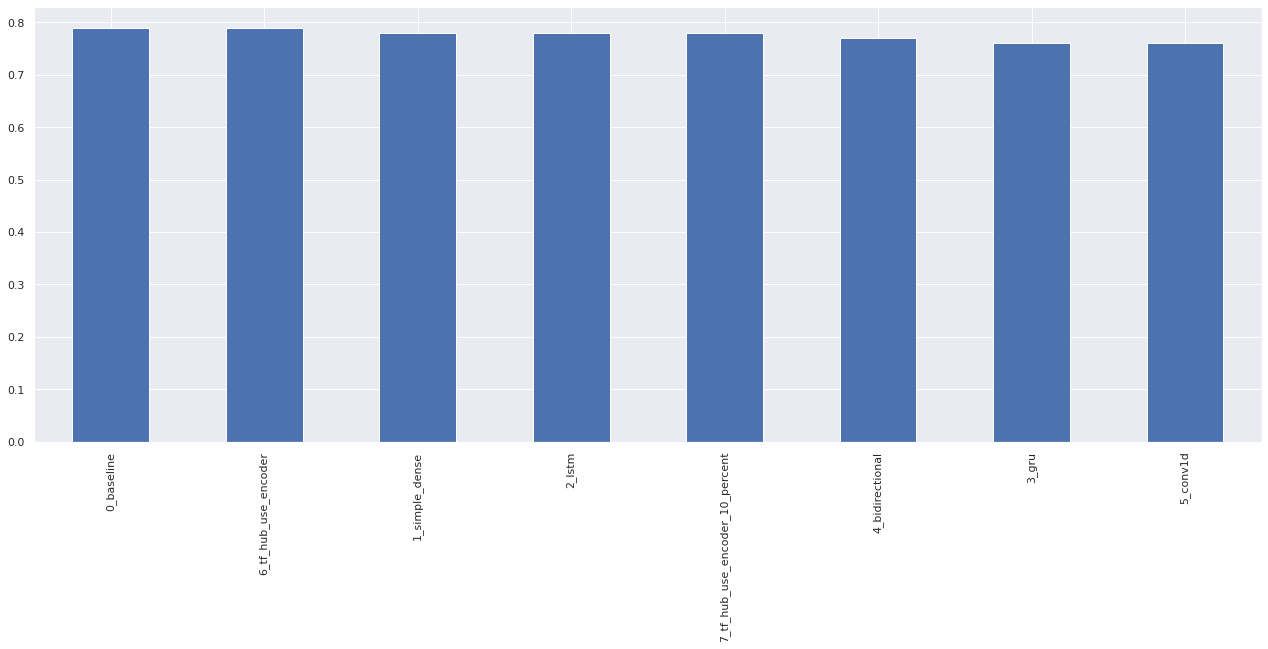

In [98]:
all_model_results.sort_values('f1', ascending=False)['f1'].plot.bar(figsize=(22, 8));


# Uploading our model's training logs to TensorBoard and comparing them

In [99]:
!tensorboard dev upload \
    --logdir ./model_logs/ \
    --name "NLP Modelling Experiment" \
    --description "Comparing multiple differnt types of model architectures on the Kaggle Tweets text classifcation dataset" \
    --one_shot

2022-04-09 05:39:02.980649: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg

In [100]:
!tensorboard dev list

2022-04-09 05:44:36.912254: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
https://tensorboard.dev/experiment/nj6DtK6vRVek5oRlet4B3Q/
	Name                 NLP Modelling Experiment
	Description          Comparing multiple differnt types of model architectures on the Kaggle Tweets text classifcation dataset
	Id                   nj6DtK6vRVek5oRlet4B3Q
	Created              2022-04-09 05:39:31 (5 minutes ago)
	Updated              2022-04-09 05:39:43 (5 minutes ago)
	Runs                 26
	Tags                 5
	Scalars              390
	Tensor bytes         0
	Binary object bytes  8439693
Total: 1 experiment(s)


In [101]:
!tensorboard dev delete --experiment_id nj6DtK6vRVek5oRlet4B3Q

2022-04-09 05:45:47.984762: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Deleted experiment nj6DtK6vRVek5oRlet4B3Q.


# Saving and loading in a trained NLP model with TensorFlow

In [102]:
model_6_results

{'accuracy': 79.27, 'f1': 0.79, 'precision': 0.79, 'recall': 0.79}

In [103]:
model_6.save('model_6.h5')

In [104]:
loaded_model_6 = tfk.models.load_model('/content/model_6.h5',
                                       custom_objects={'KerasLayer': hub.KerasLayer})

In [106]:
print(loaded_model_6.evaluate(val_sentences, val_labels))
print(model_6_results)

24/24 [==============================] - 0s 17ms/step - loss: 0.4968 - accuracy: 0.7927
[0.49679917097091675, 0.7926509380340576]
{'accuracy': 79.27, 'precision': 0.79, 'recall': 0.79, 'f1': 0.79}


# Downloading a pretrained model and preparing data to investigate predictions

In [107]:
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2022-04-09 06:02:58--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.128, 74.125.129.128, 74.125.124.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M   110MB/s    in 9.3s    

2022-04-09 06:03:07 (98.3 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables

In [108]:
model_6_pretrained = tfk.models.load_model('08_model_6_USE_feature_extractor')
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 21ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723119258880615, 0.8162729740142822]

In [109]:
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
print(model_6_pretrained_preds[:5])

tf.Tensor([0. 1. 1. 0. 1.], shape=(5,), dtype=float32)


In [112]:
val_df = pd.DataFrame({'text': val_sentences,
                       'target': val_labels,
                       'pred': model_6_pretrained_preds,
                       'pred_prob': tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [114]:
most_wrong = val_df[val_df['target'] != val_df['pred']].sort_values('pred_prob', ascending=False)
most_wrong.head()

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213


# Visualising our model's most wrong predictions

In [117]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[-10:].itertuples():
    _, text, target, pred, pred_prob = row
    print(f'Target: {target}, Pred: {pred}, Prob: {pred_prob}')
    print(f'Text: {text}')
    print('---')

Target: 1, Pred: 0.0, Prob: 0.06730341911315918
Text: @DavidVonderhaar At least you were sincere ??
---
Target: 1, Pred: 0.0, Prob: 0.05507582426071167
Text: @willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu
---
Target: 1, Pred: 0.0, Prob: 0.054603368043899536
Text: Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets
---
Target: 1, Pred: 0.0, Prob: 0.05459702014923096
Text: going to redo my nails and watch behind the scenes of desolation of smaug ayyy
---
Target: 1, Pred: 0.0, Prob: 0.049637287855148315
Text: You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.
---
Target: 1, Pred: 0.0, Prob: 0.043918460607528687
Text: @SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren
---
Target: 1, Pred: 0.0, Prob: 0.04208683967590332

In [116]:
# Check the false negatives (model predicted 0 when should've been 1)
for row in most_wrong[10:].itertuples():
    _, text, target, pred, pred_prob = row
    print(f'Target: {target}, Pred: {pred}, Prob: {pred_prob}')
    print(f'Text: {text}')
    print('---')

Target: 0, Pred: 1.0, Prob: 0.7626620531082153
Text: The Sound of Arson
---
Target: 0, Pred: 1.0, Prob: 0.7472230195999146
Text: Deaths 3 http://t.co/nApviyGKYK
---
Target: 0, Pred: 1.0, Prob: 0.7471619844436646
Text: FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday
---
Target: 0, Pred: 1.0, Prob: 0.7424100637435913
Text: åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Tent Collapse Story: Correction: Tent Collapse story åÈ http://t.co/fDJUYvZMrv @wizkidayo
---
Target: 0, Pred: 1.0, Prob: 0.7399969100952148
Text: A look at state actions a year after Ferguson's upheaval http://t.co/GZEkQWzijq
---
Target: 0, Pred: 1.0, Prob: 0.7380801439285278
Text: The #tubestrike is because TFL workers may have trouble planning downtime. I hope none need emergency services. http://t.co/iCSFDSiFqb
---
Target: 0, Pred: 1.0, Prob: 0.73566073179245
Text: @BrodyFrieling @hanna_brooksie photo bombed
---
Target: 0, Pred: 1.0, Prob: 0.716756284236908
T

# Making and visualising predictions on the test dataset

In [122]:
test_sentences = test_df['text'].to_list()
print(test_sentences[:5], '\n')

test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
    pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample]))
    pred = tf.round(pred_prob)
    print(f'Pred: {int(pred)}, Prob: {pred_prob}')
    print(f'Text: {test_sample}')
    print('-----')

['Just happened a terrible car crash', 'Heard about #earthquake is different cities, stay safe everyone.', 'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all', 'Apocalypse lighting. #Spokane #wildfires', 'Typhoon Soudelor kills 28 in China and Taiwan'] 

Pred: 0, Prob: 0.104428231716156
Text: @Sawyer_DAA @GuerrillaDawg worst feel in DS when u panicking during  boss fight and you chug two estus and the boss kills you while u drink
-----
Pred: 0, Prob: 0.10681039094924927
Text: Idk if ithats thunder or people rolling in their trashcans ??????
-----
Pred: 0, Prob: 0.10922986268997192
Text: We're about to demolish the other team right after we eat this pizza. We don't need no fitness- Ashton Irwin #MTVHottest 5SOS #5sosquotes
-----
Pred: 0, Prob: 0.05009758472442627
Text: Just blew you up @abbss_13 just so I can get that follow back ????
-----
Pred: 0, Prob: 0.37357455492019653
Text: #NuclearPower Global Nuclear Reactor Construction Market gre

# Understanding the concept of the speed/score tradeoff

In [136]:
def pred_timer(model, samples):
    start_time = time.perf_counter()
    model.predict(samples)
    end_time = time.perf_counter()
    total_time = end_time - start_time
    time_per_pred = total_time / len(samples)
    
    return round(total_time, 4), round(time_per_pred, 4)

In [137]:
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6_pretrained, 
                                                            samples=val_sentences)
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)

print(model_6_total_pred_time, model_6_time_per_pred)
print(baseline_total_pred_time, baseline_time_per_pred)

0.4795 0.0006
0.0246 0.0


In [138]:
model_6_pretrained_results = calculate_results(y_true=val_labels,
                                               y_pred=model_6_pretrained_preds)

Text(0, 0.5, 'F1-score')

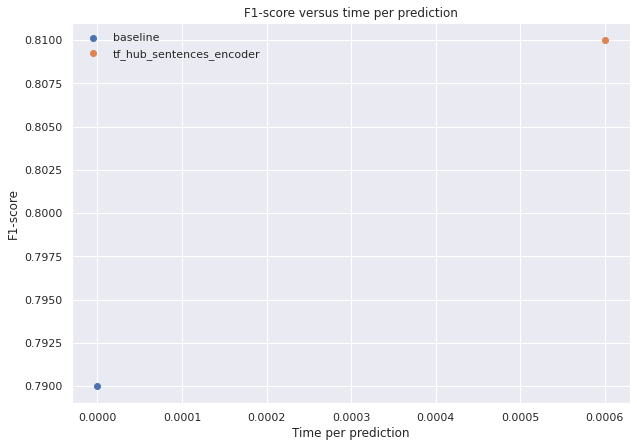

In [139]:
plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results['f1'], label='baseline')
plt.scatter(model_6_time_per_pred, model_6_pretrained_results['f1'], label='tf_hub_sentences_encoder')
plt.legend()
plt.title('F1-score versus time per prediction')
plt.xlabel('Time per prediction')
plt.ylabel('F1-score')